In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import PyLasMech as plm

### Read well log datas

In [2]:
LogFiles=plm.FileFinder("../Data/Petrophysics")

[IO] Found 9 log files


,FileName,Location
0,15_9-F-11B_INPUT.LAS,..\Data\Petrophysics\15_9-F-11B\15_9-F-11B_INP...
1,15_9-F-12_INPUT.LAS,..\Data\Petrophysics\15_9-F-12\15_9-F-12_INPUT...
2,15_9-F-14_INPUT.las,..\Data\Petrophysics\15_9-F-14\15_9-F-14_INPUT...
3,15_9-F-15C_INPUT.las,..\Data\Petrophysics\15_9-F-15C\15_9-F-15C_INP...
4,15_9-F-15D_INPUT.LAS,..\Data\Petrophysics\15_9-F-15D\15_9-F-15D_INP...
5,15_9-F-1B_INPUT.LAS,..\Data\Petrophysics\15_9-F-1B\15_9-F-1B_INPUT...
6,15_9-F-1C_INPUT.LAS,..\Data\Petrophysics\15_9-F-1C\15_9-F-1C_INPUT...
7,15_9-F-4_INPUT.las,..\Data\Petrophysics\15_9-F-4\15_9-F-4_INPUT.las
8,15_9-F-5_INPUT.las,..\Data\Petrophysics\15_9-F-5\15_9-F-5_INPUT.las


In [3]:
WellLog=plm.ReadLas(LogFiles[8])
#Print las file summary table
plm.printLas(WellLog)

[IO] Reading F:\Course\PETE 4241\Projects\Data\Petrophysics\15_9-F-5\15_9-F-5_INPUT.las.....
Done!
[LAS Info]
Well Name= 15/9-F-5
Start/Step/End Depth=(1382.000000:0.500000:12441.000000)
NULL value= -999.25
Common Depth= (10652.5, 12356.5)


,Curves,Available Depth (Non-NULL),Raw Min/Max Val,Unit,Comments
0,DEPTH:1,"[1382.0, 12441.0]","[1382.0, 12441.0]",F,DEPTH (BOREHOLE) {F10.1}
1,DEPTH:2,"[1382.0, 12441.0]","[165840.0, 1492920.0]",.1IN,Measured Depth {I11}
2,CALI,"[10652.5, 12404.0]","[-3932.3931, 8.8083]",INCHES,CALI:UNKNOWN:rC:NONE:v1 {F13.4}
3,DRHO,"[9283.0, 12441.0]","[-4486.7513, 0.52]",g/cm3,DRHO:UNKNOWN:rC:NONE:v1 {F13.4}
4,DT,"[9573.5, 12356.5]","[-4579.9872, 125.3938]",us/ft,DT:UNKNOWN:rC:NONE:v1 {F13.4}
5,GR,"[1382.0, 12441.0]","[5.063, 1707.999]",API,GR:UNKNOWN:rC:NONE:v1 {F13.4}
6,NPHI,"[9283.0, 12441.0]","[-4486.5354, 1.3]",V/V_DECIMAL,NPHI:UNKNOWN:rC:NONE:v1 {F13.4}
7,RD,"[10652.5, 12399.5]","[-3921.1475, 200.0]",UNKNOWN,RD:UNKNOWN:rC:NONE:v1 {F13.4}
8,RHOB,"[9283.0, 12441.0]","[-4492.2977, 3.0392]",g/cm3,RHOB:UNKNOWN:rC:NONE:v1 {F13.4}
9,RS,"[1382.0, 12441.0]","[0.052, 5000.0]",UNKNOWN,RS:UNKNOWN:rC:NONE:v1 {F13.4}


### Geomechanical properties calculation

> ##### Parameter and unit setup

In [4]:
#Unit Converter
ft=0.3048 #m
g_cm3=1000 #kg/m3
g=9.8 #m/s2
meter=1
mega=1e6 #Mega
Pa=1 #Pa
us=0.000001 #us, micro seconds
psi=6894.76

#Basic paramters for Volve field
rho_w=1.0*g_cm3  #formation fluid density
rho_m=2.65*g_cm3 #rock matrix density
z_w=80*meter # ocean water depth @ https://www.offshore-technology.com/projects/volve-oil-field-north-sea/
RHOB_avg=1.75*g_cm3 # average bulk density above the reservoir, Z<2576 ft
phi0=0.37
beta=0.0266*(1/mega*Pa) #convert it unit back to Pa


#RHOB DT DTS etc from Log
l=WellLog
param=l.plm_param
GeoMechParams={}


#RHOB DT DTS etc from Log
NonNanIndex=param.getCommonNonNanIndex(l,["RHOB","DT","DTS"])

DZ=l[0][NonNanIndex]
#Auto unit setup
if(param.Units[0]=="F" or param.Units[0]=="f"): DZ=DZ*ft
elif(param.Units[0]=="M" or param.Units[0]=="m"): DZ=DZ*meter
else:print("!!!Unknown Unit!!!!")
    
if("RHOB" in param.CurveNames): 
    RHOB=l["RHOB"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("RHOB")]
    if(unit=="g/cm3"): RHOB=RHOB*g_cm3
    else:print("!!!Unknown Unit!!!!",unit)    
if("DT" in param.CurveNames): 
    DT=l["DT"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DT")]
    if(unit=="us/ft"): DT=DT*us/ft
    else:print("!!!Unknown Unit!!!!",unit)  
if("DTS" in param.CurveNames): 
    DTS=l["DTS"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DTS")]
    if(unit=="us/ft"): DTS=DTS*us/ft
    else:print("!!!Unknown Unit!!!!",unit)   

> ##### Vertical stress & its gradient
$$
S_v=\rho _wgz_w+\bar{\rho}_bg\left( z_0-z_w \right) +\int_{z_0-z_w}^z{\rho _b\left( z \right) gdz}
$$

In [5]:
z_0=DZ[0]

#1. Overburden stress
Sv0=rho_w*g*z_w+RHOB_avg*g*(z_0-z_w)
Sv=[Sv0]+list(Sv0+integrate.cumtrapz(RHOB*g, DZ))
GeoMechParams["Sv"]=np.array(Sv)
GeoMechParams["Sv_grad"]=GeoMechParams["Sv"]/DZ

plm.showTable([DZ/1e3,GeoMechParams["Sv"]/1e6],['Depth_GOM(km)','Sv(MPa)'],preview=10)

+----+-----------------+-----------+
|    |   Depth_GOM(km) |   Sv(MPa) |
|----+-----------------+-----------|
|  0 |         2.918   |   49.4557 |
|  1 |         3.00289 |   51.5534 |
|  2 |         3.08778 |   53.7105 |
|  3 |         3.17266 |   55.836  |
|  4 |         3.25755 |   57.9981 |
|  5 |         3.34244 |   60.0993 |
|  6 |         3.42732 |   62.1809 |
|  7 |         3.51221 |   64.2236 |
|  8 |         3.5971  |   66.1282 |
|  9 |         3.68198 |   68.0295 |
+----+-----------------+-----------+


> ##### Hydrostatic pressure in MPa.  
The pore pressure can be calculated as follows:  
$${{P}_{p}}={{\bar{\rho }}_{w}}g{z} $$

In [6]:
GeoMechParams["P_pore"]=rho_w*g*DZ

plm.showTable([DZ/1e3,GeoMechParams["P_pore"]/1e6],['Depth_GOM(km)','PorePressure(MPa)'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   PorePressure(MPa) |
|----+-----------------+---------------------|
|  0 |         2.918   |             28.5964 |
|  1 |         3.00289 |             29.4283 |
|  2 |         3.08778 |             30.2602 |
|  3 |         3.17266 |             31.0921 |
|  4 |         3.25755 |             31.924  |
|  5 |         3.34244 |             32.7559 |
|  6 |         3.42732 |             33.5878 |
|  7 |         3.51221 |             34.4197 |
|  8 |         3.5971  |             35.2516 |
|  9 |         3.68198 |             36.0834 |
+----+-----------------+---------------------+


> ##### Rock porosity
The rock porosity can be calculated using density log as follows:  
$$
\phi =\frac{\rho _m-\rho _b}{\rho _m-\rho _w}
$$

In [7]:
GeoMechParams["PORO"]=(rho_m-RHOB)/(rho_m-rho_w)

plm.showTable([DZ/1e3,GeoMechParams["PORO"]],['Depth_GOM(km)','Porosity'],preview=10)

+----+-----------------+-------------+
|    |   Depth_GOM(km) |    Porosity |
|----+-----------------+-------------|
|  0 |         2.918   | 0.539394    |
|  1 |         3.00289 | 0.00606061  |
|  2 |         3.08778 | 0.0424242   |
|  3 |         3.17266 | 0.00606061  |
|  4 |         3.25755 | 0.0242424   |
|  5 |         3.34244 | 0.0849697   |
|  6 |         3.42732 | 0.0848485   |
|  7 |         3.51221 | 0.193939    |
|  8 |         3.5971  | 0.000606061 |
|  9 |         3.68198 | 0.26        |
+----+-----------------+-------------+


> ##### Porosity by Athy's equation  
The effective vertical stress $\sigma'_v$ can be calculated as follows:
$$\sigma'_v=\sigma_v - p_p $$
The porosity can be calculated as follows:
$$\phi=\phi_0 e^{-\beta \sigma'_v} $$

In [8]:
Sv_eff=GeoMechParams["Sv"]-GeoMechParams["P_pore"]
plm.showTable([DZ/1e3,Sv_eff/1e6],['Depth_GOM(km)','Effective Sv(MPa)'],preview=10)

GeoMechParams["PORO_Athy"]=phi0*np.exp(-beta*Sv_eff)
plm.showTable([DZ/1e3,GeoMechParams["PORO_Athy"]],['Depth_GOM(km)','Porosity_Athy'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   Effective Sv(MPa) |
|----+-----------------+---------------------|
|  0 |         2.918   |             20.8593 |
|  1 |         3.00289 |             22.1251 |
|  2 |         3.08778 |             23.4503 |
|  3 |         3.17266 |             24.7439 |
|  4 |         3.25755 |             26.0741 |
|  5 |         3.34244 |             27.3435 |
|  6 |         3.42732 |             28.5932 |
|  7 |         3.51221 |             29.8039 |
|  8 |         3.5971  |             30.8766 |
|  9 |         3.68198 |             31.946  |
+----+-----------------+---------------------+
+----+-----------------+-----------------+
|    |   Depth_GOM(km) |   Porosity_Athy |
|----+-----------------+-----------------|
|  0 |         2.918   |        0.212437 |
|  1 |         3.00289 |        0.205403 |
|  2 |         3.08778 |        0.198289 |
|  3 |         3.17266 |        0.191582 |
|  4 |         3.25755 |        0.184922 

> ##### Pore pressure by Athy's equation
The Pore pressure by Athy's can be calculated as follows:  
$$ p_p = \sigma_v +\frac{1}{\beta}\ln{\frac{\phi}{\phi_0}} $$

In [9]:
GeoMechParams["P_pore_Athy"]=GeoMechParams["Sv"]+1/beta*np.log(GeoMechParams["PORO"]/phi0)

plm.showTable([DZ/1e3,GeoMechParams["P_pore_Athy"]/1e6],['Depth_GOM(km)','PorePressure_Athy(MPa)'],preview=10)

+----+-----------------+--------------------------+
|    |   Depth_GOM(km) |   PorePressure_Athy(MPa) |
|----+-----------------+--------------------------|
|  0 |         2.918   |                 63.6265  |
|  1 |         3.00289 |               -103.022   |
|  2 |         3.08778 |                -27.7099  |
|  3 |         3.17266 |                -98.7389  |
|  4 |         3.25755 |                -44.4605  |
|  5 |         3.34244 |                  4.79076 |
|  6 |         3.42732 |                  6.81868 |
|  7 |         3.51221 |                 39.9395  |
|  8 |         3.5971  |               -175.01    |
|  9 |         3.68198 |                 54.7655  |
+----+-----------------+--------------------------+


c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [10]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

In [11]:
plm.appendCurve(l,'Sv', GeoMechParams["Sv"]/1e6, unit='MPa',descr='PyLasMech overburden stress',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore', GeoMechParams["P_pore"]/1e6, unit='MPa',descr='PyLasMech pore pressure',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO', GeoMechParams["PORO"], unit='-',descr='PyLasMech porosity',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO_Athy', GeoMechParams["PORO_Athy"], unit='-',descr='PyLasMech porosity from Athy',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore_Athy', GeoMechParams["P_pore_Athy"]/1e6, unit='MPa',descr='PyLasMech pore pressure from Athy',dataIndex=NonNanIndex)

Input data size(5567) < DEPTH size (22119), NULL value (nan) will be added
Input data size(5567) < DEPTH size (22119), NULL value (nan) will be added
Input data size(5567) < DEPTH size (22119), NULL value (nan) will be added
Input data size(5567) < DEPTH size (22119), NULL value (nan) will be added
Input data size(5567) < DEPTH size (22119), NULL value (nan) will be added


> ##### (b) Shear modulus (G,MPa), Possion ratio and Youngs Modulus (E, MPa) only available for DT/DTS
$$
G=\rho_bV_{s}^{2}
\\
\nu =\frac{V_{p}^{2}-2V_{s}^{2}}{2\left( V_{p}^{2}-V_{s}^{2} \right)}
\\
E=2G\left( 1+\nu \right) 
$$

In [12]:
Vp=1/DT
Vs=1/DTS

plm.showTable([DZ/1e3,Vp,Vs],
           ['Depth(km)','$V_p$ (m/s)','$V_s$ (m/s)'])

GeoMechParams["G"]=RHOB*Vs*Vs
GeoMechParams["v"]=(Vp**2-2*Vs**2)/2/(Vp**2-Vs**2)
GeoMechParams["E"]=2*GeoMechParams["G"]*(1+GeoMechParams["v"]) 

plm.showTable([DZ/1e3,GeoMechParams["G"]/1e9,GeoMechParams["v"],GeoMechParams["E"]/1e9],['Depth(km)','G(GPa)','v','E(GPa)'])

NameError: name 'DTS' is not defined

In [ ]:
GeoMechParams["UCS"]=np.exp(-6.36+2.45*np.log10(0.86*Vp-1172))*mega*Pa
plm.showTable([DZ/1e3,GeoMechParams["UCS"]/1e6],['Depth(km)','UCS(MPa)'],preview=10)

In [ ]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

#plm.appendCurve(l,'G', GeoMechParams["G"]/1e9, unit='GPa',descr='PyLasMech Bulk modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'v', GeoMechParams["v"], unit='-',descr='PyLasMech possion ratio',dataIndex=NonNanIndex)
plm.appendCurve(l,'E', GeoMechParams["E"]/1e9, unit='GPa',descr='PyLasMech Youngs modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'UCS', GeoMechParams["UCS"]/1e6, unit='MPa',descr='PyLasMech UCS',dataIndex=NonNanIndex)

### Plot and visulization

	Auto Depth Range= (9573.5, 12356.5) for  ['Sv', 'P_pore', 'PORO', 'PORO_Athy', 'P_pore_Athy']
	 P_pore_Athy Corrected Min/Max Val [-268.57152876867116, 83.29910296659935]


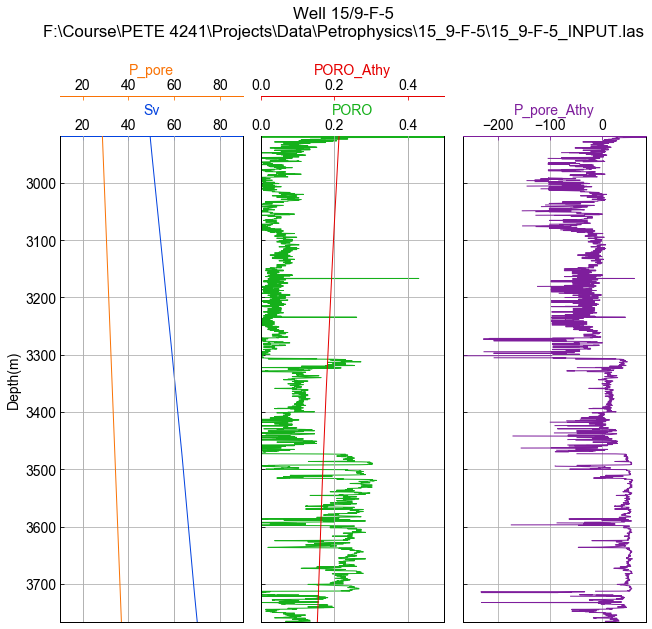

In [13]:
XLims={"P_pore":(10,90),"Sv":(10,90),"PORO_Athy":(0,0.5),"PORO":(0,0.5)}
fig=plm.plotLogs(LogData=l,CurveNames=GeoMechParams.keys(),XLims=XLims)